## <span style="color:#db7d60">Setup</span>

In [1]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

In [6]:
anal.plotting.default_dpi = 100

# IMPORTANT: This function assumes ALL provided models are from the same dataset!!!!
@staticmethod
def compare_distributions_leading(model_names, column_name=None, normalized=False, use_log=False, out_file=None):
    assert column_name in anal.plotting.verbose_columns, f"Invalid column name: {column_name}. Must be one of {anal.plotting.verbose_columns}."
    unit = ''
    if column_name in ['e', 'pt', 'px', 'py', 'pz']:
        unit = '(MeV)'
    elif column_name in ['eta', 'theta', 'phi']:
        unit = '(angular)'
    
    # Set up plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=False, sharey=True, dpi=anal.plotting.default_dpi)
    fig.suptitle(f'{column_name} Distribution for Leading Particles {"(Normalized)" if normalized else ""}')
    fig.supxlabel(f'{column_name} {unit}')
    fig.supylabel('log(Frequency)' if use_log else 'Frequency')
    
    # This data will be grabbed from the first model to maintain consistency
    bin_settings = anal.plotting.get_common_data(model_names[0])
    range = (bin_settings[column_name]['min'], bin_settings[column_name]['max'])
    n_bins = bin_settings[column_name]['bins']
        
    relevant_column_pos = anal.plotting.verbose_columns.index(column_name)
    
    # The input data
    real_verbose_data = data_manager.load_verbose_dataset(pUtil.get_model_preparation_dir(model_names[0]) / 'real_verbose_test_particles.csv', pad_token = np.nan)
    all_instances_of_this_column_real = []
    for event in real_verbose_data:
        secondaries = event[1:]
        # Find index of particle with the highest energy
        leading_particle_idx = np.nanargmax(secondaries[:, 1])
        leading_particle = secondaries[leading_particle_idx]
        all_instances_of_this_column_real.append(leading_particle[relevant_column_pos])
        
    # The sampled datas
    sampled_columns_instances = {}
    for model_name in model_names:
        sampled_verbose_data = data_manager.load_verbose_dataset(pUtil.get_latest_sampling_dir(model_name) / 'untokenized_samples_verbose.csv', pad_token = np.nan)
        all_instances_of_this_column_sampled = []
        for event in sampled_verbose_data:
            secondaries = event[1:]
            # Find index of particle with the highest energy
            leading_particle_idx = np.nanargmax(secondaries[:, 1])
            leading_particle = secondaries[leading_particle_idx]
            all_instances_of_this_column_sampled.append(leading_particle[relevant_column_pos])
        sampled_columns_instances[model_name] = all_instances_of_this_column_sampled
    
    ax.set_yscale('log' if use_log else 'linear')
    ax.hist(all_instances_of_this_column_real, range=range, bins=n_bins, density=normalized, label=f'Input ({model_names[0]})', color=anal.plotting.colors[0], alpha=0.7)
    for idx, (model_name, sampled_column_instance) in enumerate(sampled_columns_instances.items()):
        ax.hist(sampled_column_instance, range=range, bins=n_bins, density=normalized, label=f'Sampled ({model_name})', color=anal.plotting.colors[idx + 1], alpha=0.7)
        
    fig.legend()
    fig.tight_layout()
    if out_file != None:
        fig.savefig(out_file, bbox_inches='tight')
    fig.show()

@staticmethod
def compare_distributions_all(model_names, column_name=None, normalized=False, use_log=False, out_file=None):
    unit = ''
    if column_name in ['e', 'pt', 'px', 'py', 'pz']:
        unit = '(MeV)'
    elif column_name in ['eta', 'theta', 'phi']:
        unit = '(angular)'
    
    # Set up plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=False, sharey=True, dpi=anal.plotting.default_dpi)
    fig.suptitle(f'{column_name} Distribution for All Outgoing Particles {"(Normalized)" if normalized else ""}')
    fig.supxlabel(f'{column_name} {unit}')
    fig.supylabel('log(Frequency)' if use_log else 'Frequency')
    
    # This data will be grabbed from the first model to maintain consistency
    bin_settings = anal.plotting.get_common_data(model_names[0])
    range = (bin_settings[column_name]['min'], bin_settings[column_name]['max'])
    n_bins = bin_settings[column_name]['bins']
    
    relevant_column_pos = anal.plotting.verbose_columns.index(column_name)
    
    # The input data
    real_verbose_data = data_manager.load_verbose_dataset(pUtil.get_model_preparation_dir(model_names[0]) / 'real_verbose_test_particles.csv', pad_token = np.nan)
    all_instances_of_this_column_real = []
    for event in real_verbose_data:
        secondaries = event[1:]
        for particle in secondaries:
            if not np.isnan(particle[relevant_column_pos]):
                all_instances_of_this_column_real.append(particle[relevant_column_pos])
    
    # The sampled datas  
    sampled_columns_instances = {}
    for model_name in model_names:
        sampled_verbose_data = data_manager.load_verbose_dataset(pUtil.get_latest_sampling_dir(model_name) / 'untokenized_samples_verbose.csv', pad_token = np.nan)
        all_instances_of_this_column_sampled = []
        for event in sampled_verbose_data:
            secondaries = event[1:]
            for particle in secondaries:
                if not np.isnan(particle[relevant_column_pos]):
                    all_instances_of_this_column_sampled.append(particle[relevant_column_pos])
        sampled_columns_instances[model_name] = all_instances_of_this_column_sampled
    
    ax.set_yscale('log' if use_log else 'linear')
    ax.hist(all_instances_of_this_column_real, range=range, bins=n_bins, density=normalized, label=f'Input ({model_names[0]})', color=anal.plotting.colors[0], alpha=0.7)
    for idx, (model_name, sampled_column_instance) in enumerate(sampled_columns_instances.items()):
        ax.hist(sampled_column_instance, range=range, bins=n_bins, density=normalized, label=f'Sampled ({model_name})', color=anal.plotting.colors[idx + 1], alpha=0.7)
        
    # Finishing touches and show and/or save
    fig.legend()
    fig.tight_layout()
    if out_file != None:
        fig.savefig(out_file, bbox_inches='tight')
    fig.show()

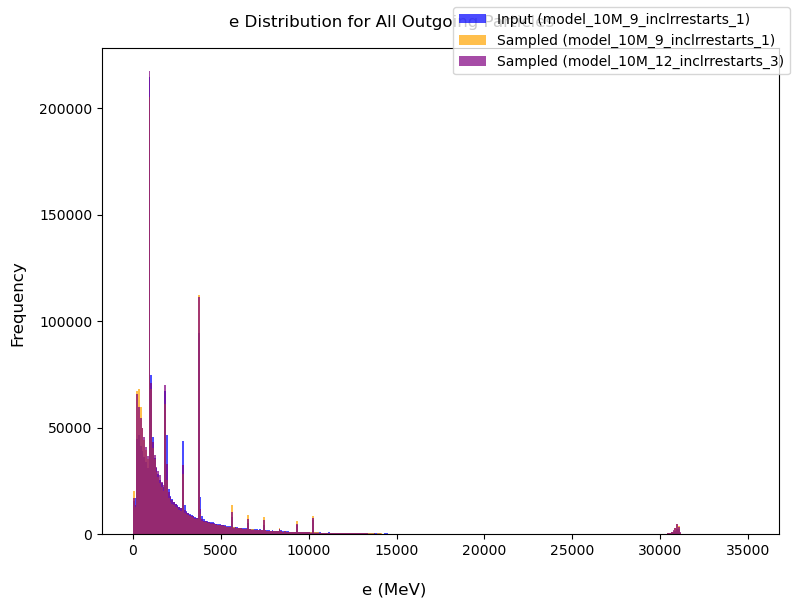

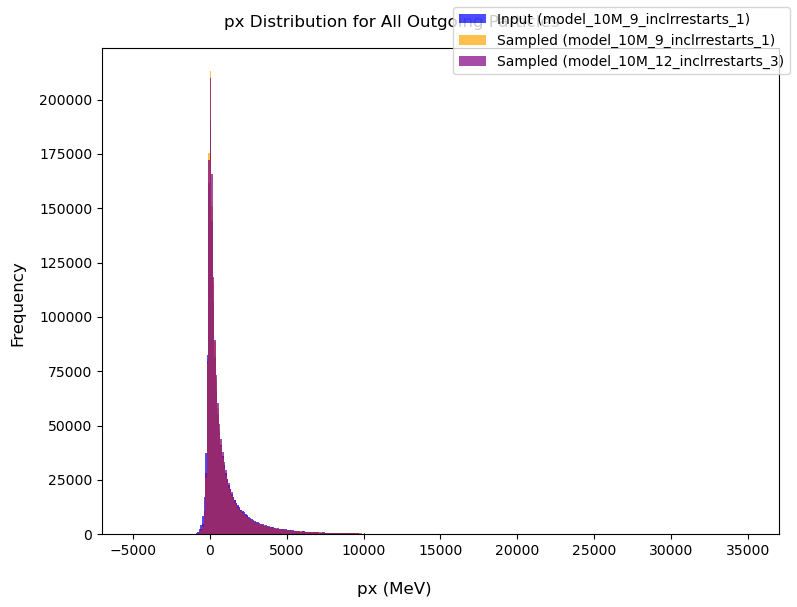

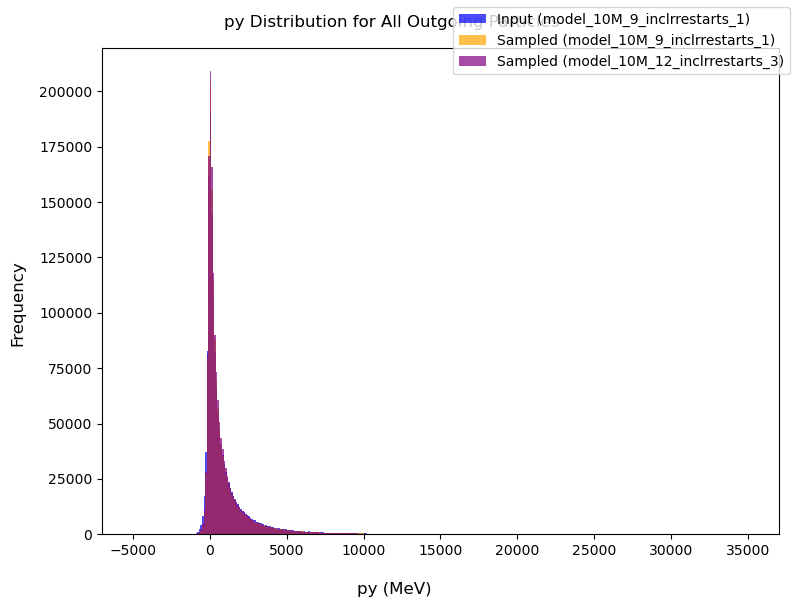

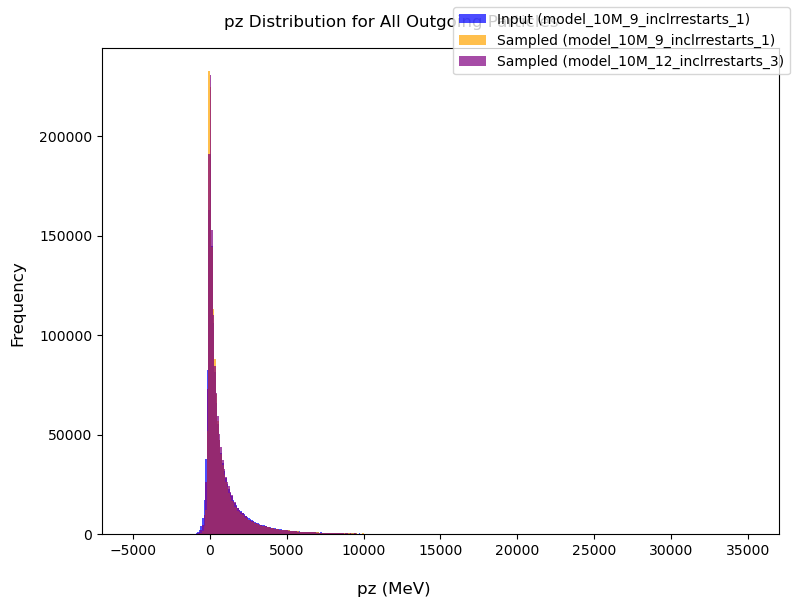

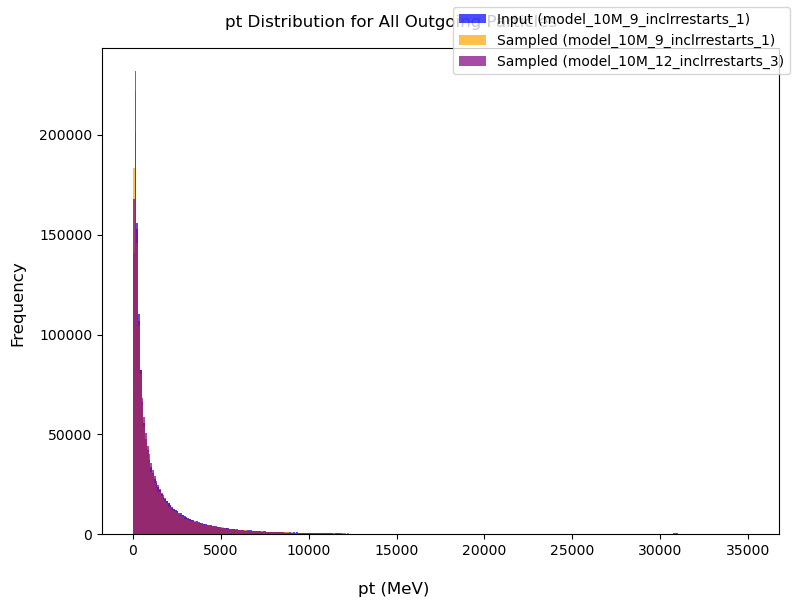

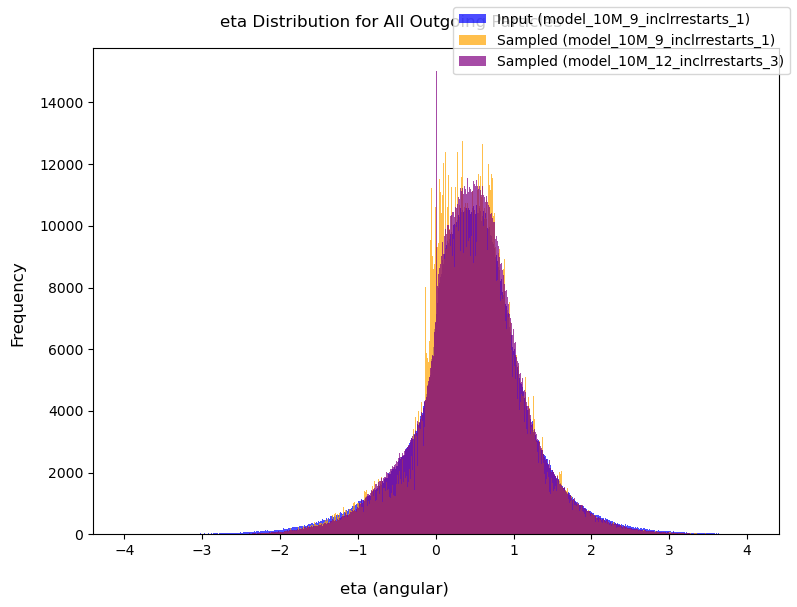

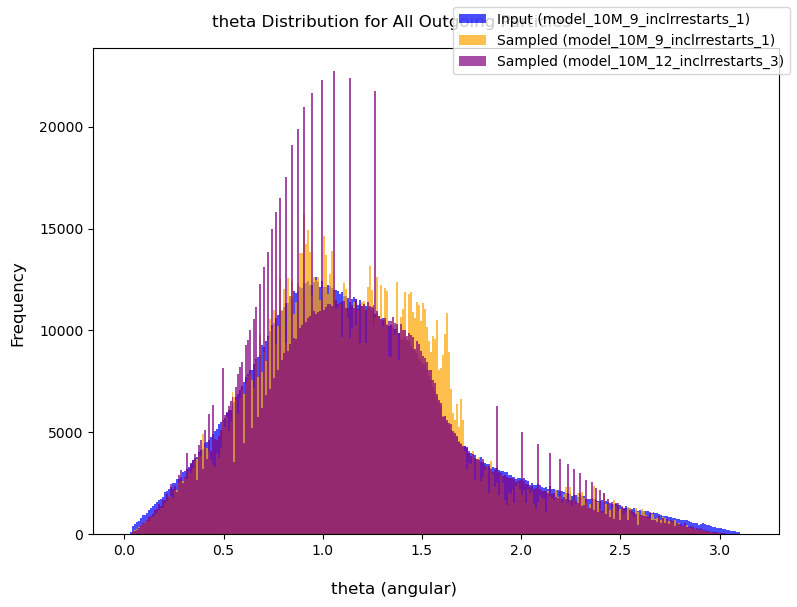

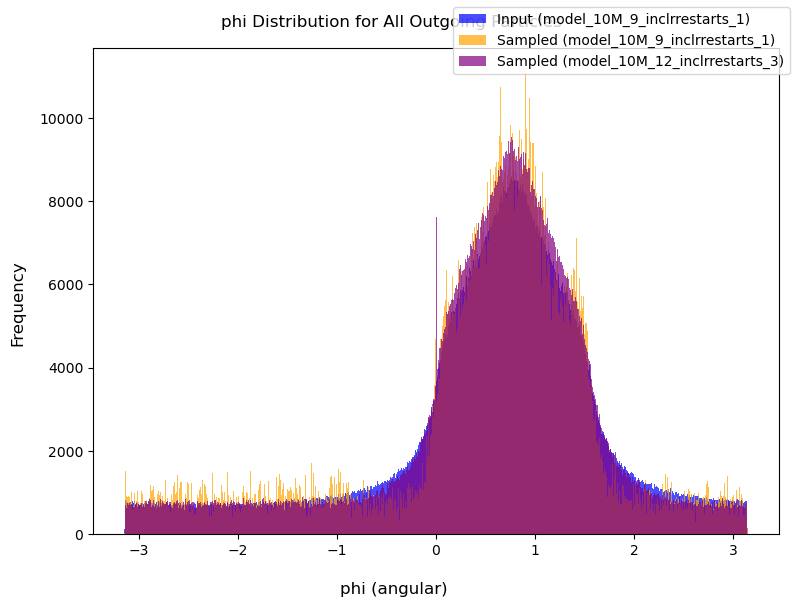

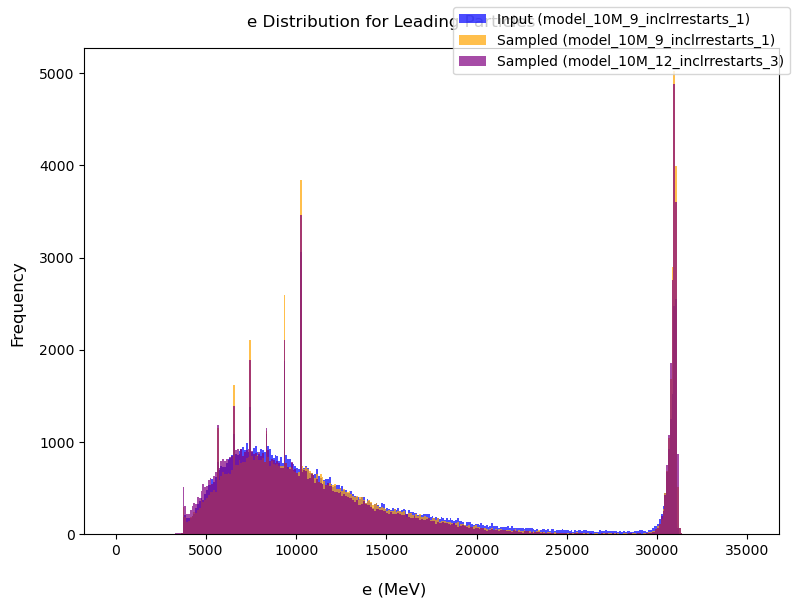

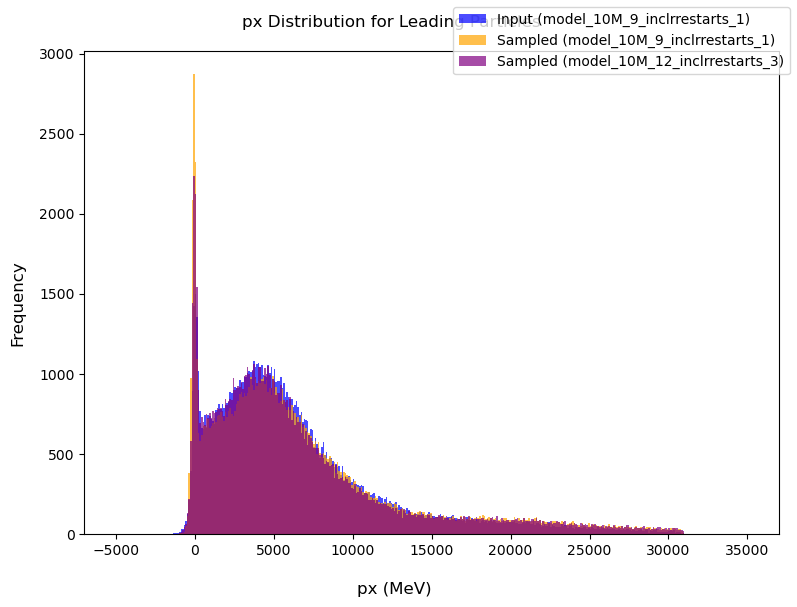

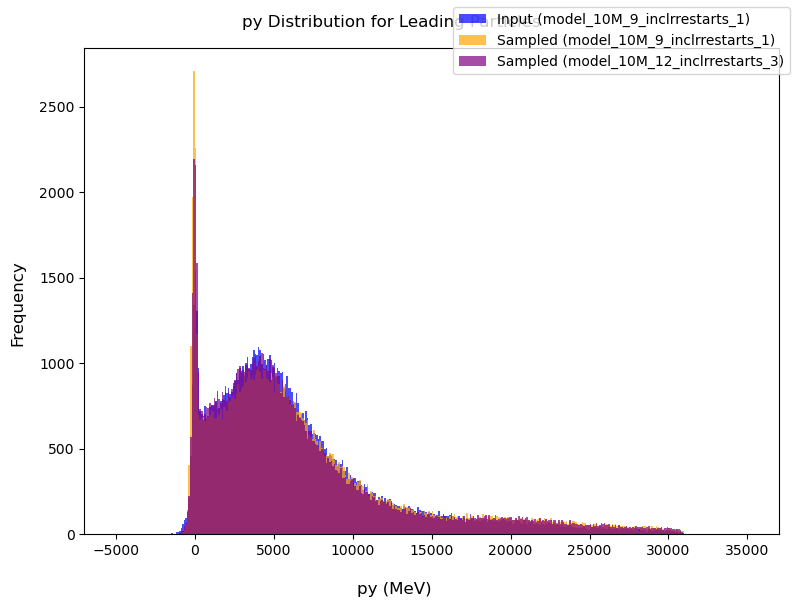

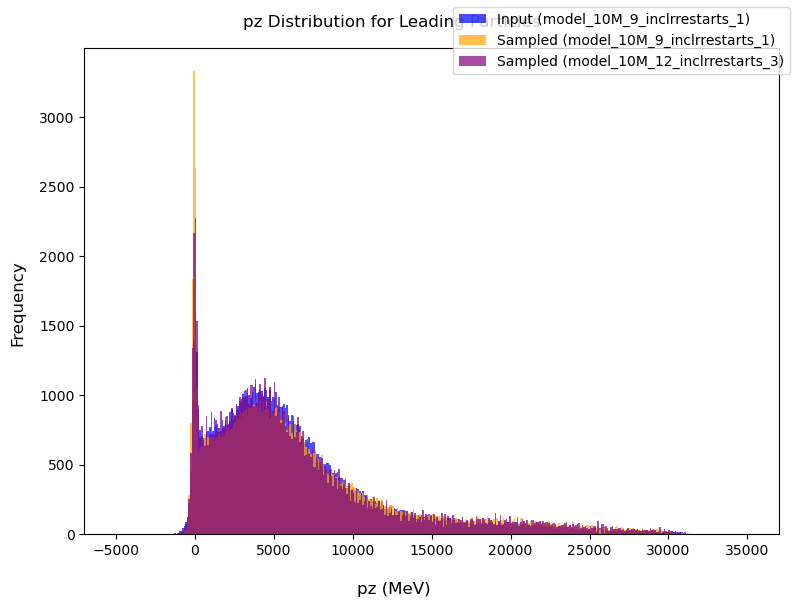

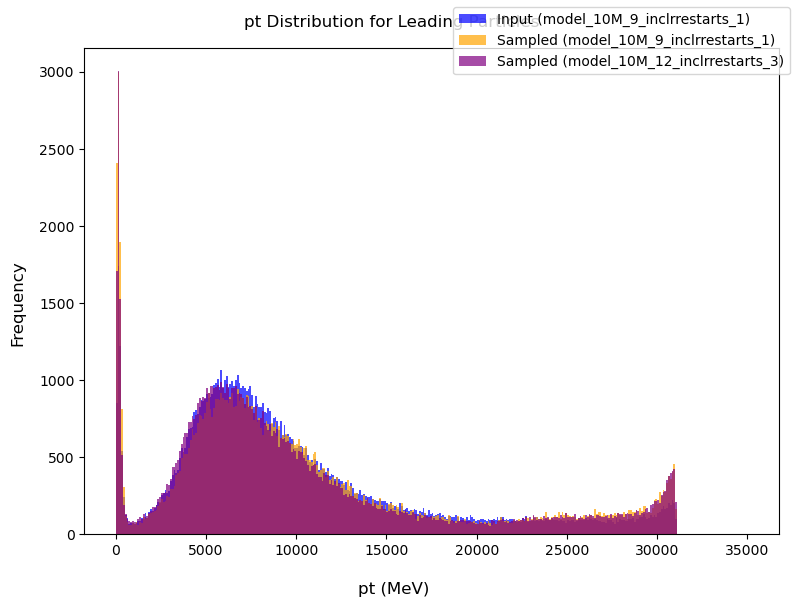

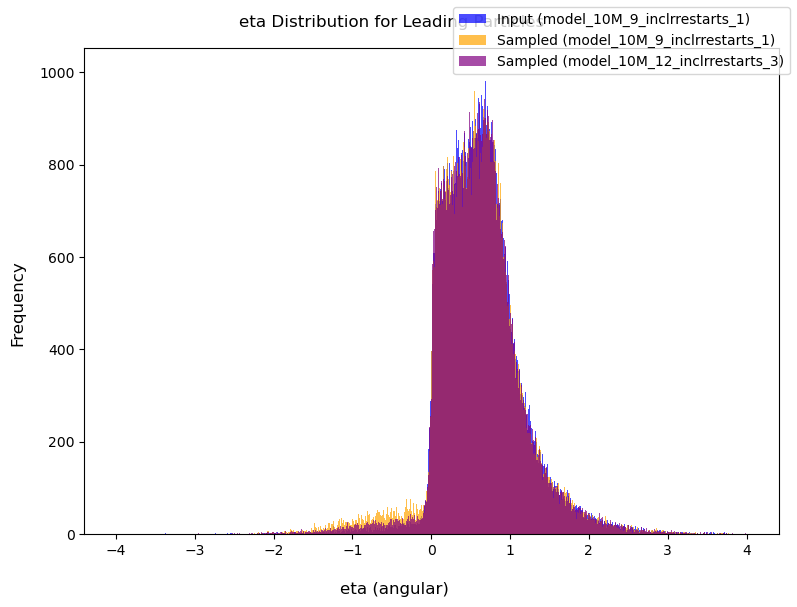

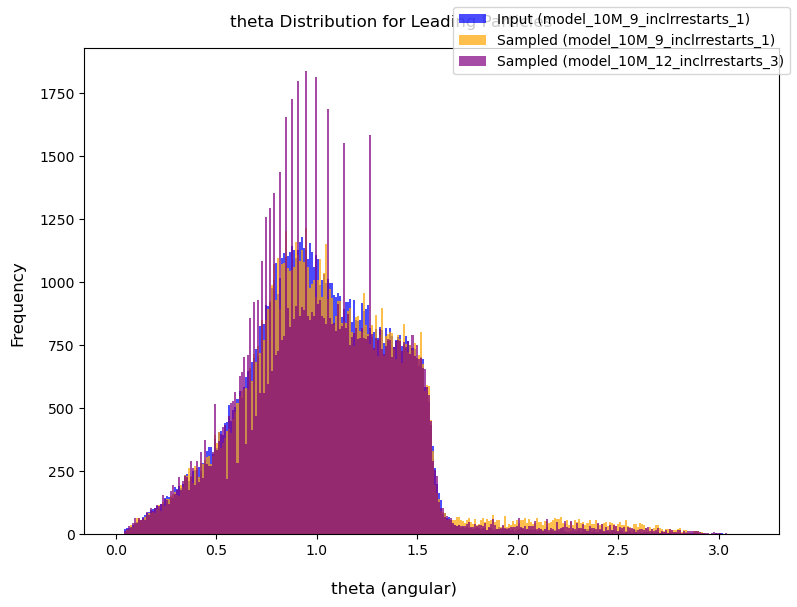

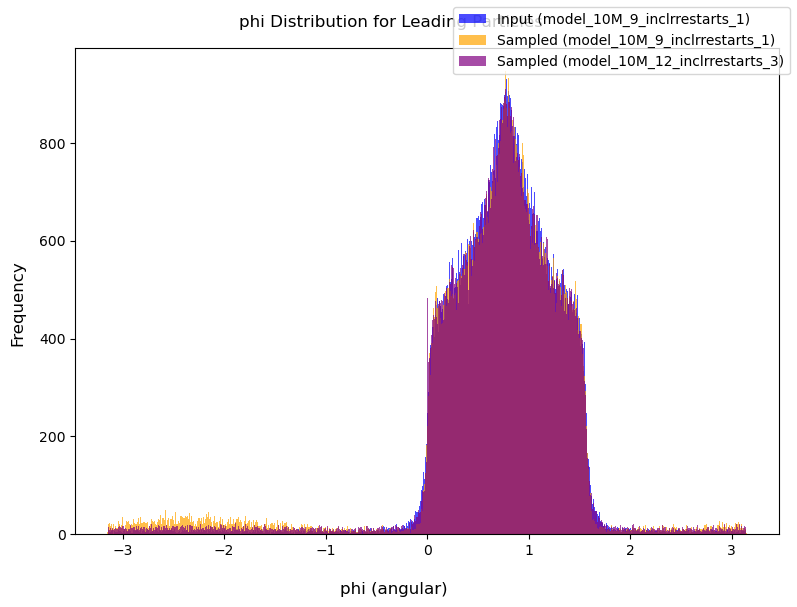

In [8]:
all_columns = ["e", "px", "py", "pz", "pt", "eta", "theta", "phi"]
models_to_compare = ['model_10M_9_inclrrestarts_1', 'model_10M_12_inclrrestarts_3']
for column in all_columns:
    compare_distributions_all(models_to_compare, column, normalized=False, use_log=False)
for column in all_columns:
    compare_distributions_leading(models_to_compare, column, normalized=False, use_log=False)